In [3]:
import os
import torch
from torch import nn
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
import torch.optim as optim
# from torchvision.transforms import v2
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
train_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])
test_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

In [3]:
train_data = datasets.ImageFolder(
    root = "training_set",
    transform = train_transform,
    target_transform = None
)

test_data = datasets.ImageFolder(
    root = "test_set",
    transform = test_transform,
    target_transform = None
)

# print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

In [4]:
class_names = train_data.classes
# class_names

In [5]:
class_dict = train_data.class_to_idx
class_dict

{'horses': 0, 'humans': 1}

In [6]:
len(train_data), len(test_data)

(1027, 256)

In [7]:
img, label = train_data[0][0], train_data[0][1]

In [8]:
img.shape

torch.Size([3, 64, 64])

In [9]:
# img, label = train_data[0][0], train_data[0][1]
# print(f"Image tensor:\n{img}")
# print(f"Image shape: {img.shape}")
# print(f"Image datatype: {img.dtype}")
# print(f"Image label: {label}")
# print(f"Label datatype: {type(label)}")

In [10]:
# # Rearrange the order of dimensions
# img_permute = img.permute(1, 2, 0)

# # Print out different shapes (before and after permute)
# print(f"Original shape: {img.shape} -> [color_channels, height, width]")
# print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# # Plot the image
# plt.figure(figsize=(10, 7))
# plt.imshow(img.permute(1, 2, 0))
# plt.axis("off")
# plt.title(class_names[label], fontsize=14);

In [11]:
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=BATCH_SIZE, # how many samples per batch?
                              num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x2538d396510>,
 <torch.utils.data.dataloader.DataLoader at 0x2538ccc4290>)

In [12]:
# img, label = next(iter(train_dataloader))

# # Batch size will now be 1, try changing the batch_size parameter above and see what happens
# print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
# print(f"Label shape: {label.shape}")

In [27]:
class CnnModel1(nn.Module):
    
     def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
         
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Dropout(0.5),
            nn.Linear(in_features=hidden_units  * 16 * 16,
                      out_features=output_shape),
        )
    
     def forward(self, x: torch.Tensor):
        
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
   

In [28]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [29]:
model1 = CnnModel1(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=64, 
                  output_shape=2)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001)

In [30]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        # X, y = X.to(device), y.to(device)
        X, y = X, y

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            # X, y = X.to(device), y.to(device)
            X, y = X, y
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [32]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [33]:
from timeit import default_timer as timer 
start_time = timer()
model1_results = train(model=model1, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=20)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6542 | train_acc: 0.6140 | test_loss: 0.7696 | test_acc: 0.5000
Epoch: 2 | train_loss: 0.4696 | train_acc: 0.7784 | test_loss: 0.6999 | test_acc: 0.5078
Epoch: 3 | train_loss: 0.2534 | train_acc: 0.8886 | test_loss: 0.8488 | test_acc: 0.5195
Epoch: 4 | train_loss: 0.1486 | train_acc: 0.9375 | test_loss: 0.4323 | test_acc: 0.7891
Epoch: 5 | train_loss: 0.0952 | train_acc: 0.9568 | test_loss: 0.3290 | test_acc: 0.8672
Epoch: 6 | train_loss: 0.1734 | train_acc: 0.9441 | test_loss: 0.5957 | test_acc: 0.7422
Epoch: 7 | train_loss: 0.0492 | train_acc: 0.9830 | test_loss: 0.6603 | test_acc: 0.7969
Epoch: 8 | train_loss: 0.0386 | train_acc: 0.9858 | test_loss: 0.4240 | test_acc: 0.8750
Epoch: 9 | train_loss: 0.0176 | train_acc: 0.9962 | test_loss: 0.6408 | test_acc: 0.8594
Epoch: 10 | train_loss: 0.0560 | train_acc: 0.9801 | test_loss: 0.3986 | test_acc: 0.8750
Epoch: 11 | train_loss: 0.0258 | train_acc: 0.9915 | test_loss: 0.4895 | test_acc: 0.8906
Epoch: 12 | train_l

In [34]:
# Check the model_0_results keys
model1_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [35]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

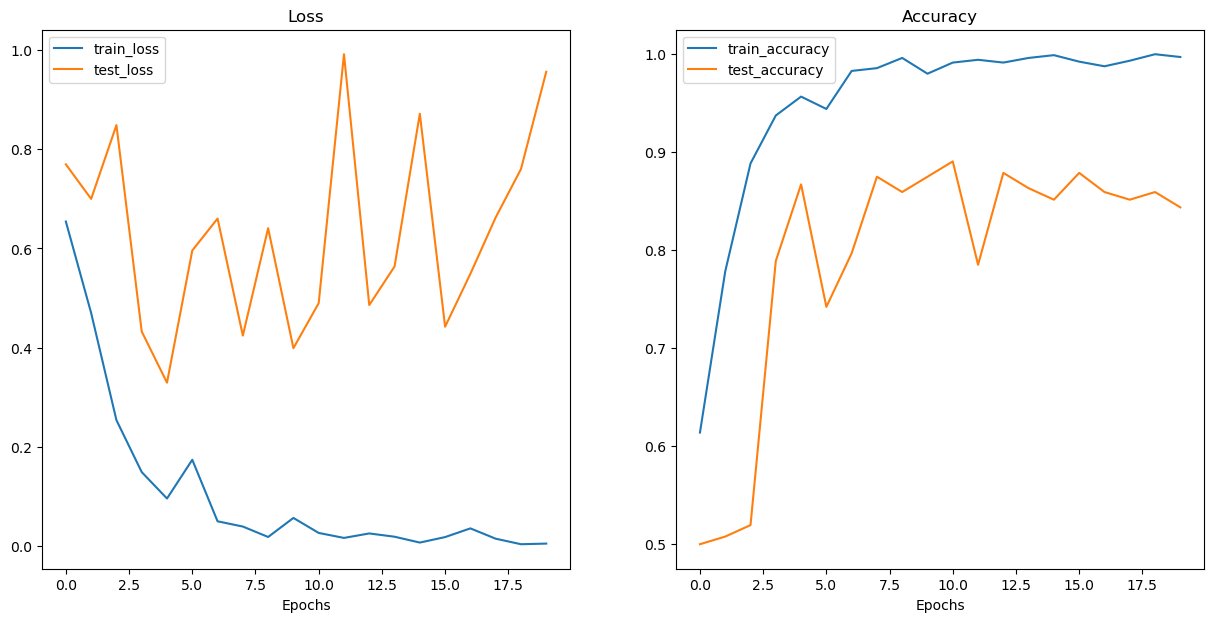

In [36]:
plot_loss_curves(model1_results)

In [46]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image('single_prediction/human1.jpg').type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.8980, 0.8902, 0.8784,  ..., 0.7843, 0.7843, 0.7843],
         [0.9020, 0.8941, 0.8863,  ..., 0.7804, 0.7804, 0.7843],
         [0.8980, 0.8980, 0.8941,  ..., 0.7765, 0.7804, 0.7804],
         ...,
         [0.9059, 0.9059, 0.9020,  ..., 0.4627, 0.4745, 0.4824],
         [0.9059, 0.9059, 0.9059,  ..., 0.4588, 0.4745, 0.4863],
         [0.9098, 0.9098, 0.9059,  ..., 0.4588, 0.4745, 0.4863]],

        [[0.8824, 0.8745, 0.8627,  ..., 0.7569, 0.7569, 0.7569],
         [0.8863, 0.8784, 0.8706,  ..., 0.7529, 0.7529, 0.7569],
         [0.8824, 0.8824, 0.8784,  ..., 0.7490, 0.7529, 0.7529],
         ...,
         [0.9137, 0.9137, 0.9098,  ..., 0.4471, 0.4588, 0.4667],
         [0.9137, 0.9137, 0.9137,  ..., 0.4431, 0.4588, 0.4706],
         [0.9176, 0.9176, 0.9137,  ..., 0.4431, 0.4588, 0.4706]],

        [[0.8353, 0.8275, 0.8157,  ..., 0.6863, 0.6863, 0.6863],
         [0.8392, 0.8314, 0.8235,  ..., 0.6824, 0.6824, 0.6863],
         [0.8353, 0.8353, 0.8314,  ..

In [47]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 5760, 3840])
New shape: torch.Size([3, 64, 64])


In [48]:
model1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    # custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))
    custom_image_pred = model1(custom_image_transformed.unsqueeze(dim=0))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [49]:
custom_image_pred

tensor([[-1.9030,  1.9813]])

In [50]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[-1.9030,  1.9813]])
Prediction probabilities: tensor([[0.0201, 0.9799]])
Prediction label: tensor([1])


In [51]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'humans'